In [1]:
!pip install -q shapely
!pip install -q --upgrade pandas
!pip install -q --upgrade fsspec
!pip install -q pandarallel
!pip install -q googlemaps
!pip install -q geopandas
!pip install -q descartes
!pip install -q awswrangler
!pip install -q arcgis
!pip install arcgis
!pip install --upgrade scikit-learn

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrad

In [3]:
import pandas as pd
import numpy as np

data = pd.read_csv('../../../Outputs/atenciones_filtradas.csv')

In [4]:
data['fecha_hora_de_asignacion_al_proveedor'] = pd.to_datetime(data['fecha_hora_de_asignacion_al_proveedor'])
data['fecha_hora_culminacion_proveedor'] = pd.to_datetime(data['fecha_hora_culminacion_proveedor'])
data['tiempo_atencion'] = (data['fecha_hora_culminacion_proveedor'] - data['fecha_hora_de_asignacion_al_proveedor']).dt.seconds / 60

data['cast_fecha_hora'] = pd.to_datetime(data['fecha_hora_de_apertura'])


In [17]:
import arcgis
import pandas as pd
from arcgis.gis import GIS

df_routes = []

portal = GIS("https://www.arcgis.com", "dante_rivas_LearnArcGIS", "POSEIDON24")
#portal = GIS("https://www.arcgis.com", "jose_rivas_LearnArcGIS2", "Poseidon#49")
route = arcgis.network.RouteLayer(portal.properties.helperServices.route.url,
                                          gis=portal)

In [6]:
from collections import Counter
def get_time_function(route):
    def get_time_distance(point:list, centers:list):
        distances = []
        for center in centers:
            stops = f"{point[1]},{point[0]};{center[1]},{center[0]}"

            result = route.solve(stops=stops,
                                    start_time="now",
                                    return_directions=False,
                                    directions_language="es",)

            time = result['routes']['features'][0]['attributes']['Total_Kilometers']
            distances.append(time)
            
        return distances
    
    return get_time_distance

In [7]:
data.sort_values(by='cast_fecha_hora', inplace=True)

In [8]:
data = data.loc[(data.fecha_hora_culminacion_proveedor.notnull()) &
               (data.cast_fecha_hora.notnull())].drop_duplicates('numero_del_caso')

In [9]:
# mañana 12 - 12pm -> tarde 12pm - 6pm -> noche 6pm -12 pm
data['cast_datetime'] = pd.to_datetime(data.fecha_hora_de_apertura)
data['cast_hour'] = data['cast_datetime'].dt.hour
data['cast_day'] = data['cast_datetime'].dt.day

def get_schedule(x):
    if x < 4 or x >=20: # -> 12
        return '8pm a 4am'
    elif x < 12:# or x > 20: # -> 12
        return 'de 4am a 12pm'
    elif x < 20: # 8-12 -> 4
        return 'de 12am a 8pm'
    else:
        return np.nan
    
def get_week(x):
    return int(x / 7)

data['cat_schedule'] = data['cast_hour'].apply(lambda x: get_schedule(x))


In [10]:
cut = data.loc[(data['mes_de_registro'] == 'Deciembre') |
              (data['mes_de_registro'] == 'Noviembre')].reset_index(drop=True)

In [11]:
from sklearn.cluster import DBSCAN
import seaborn as sns

db = DBSCAN(eps=0.05, min_samples=1).fit(cut[['lat', 'lng']])

labels = db.labels_
cut['class'] = labels

In [12]:
cut_without_noise = cut[cut['class'] == 0].reset_index(drop=True)
cut_without_noise['indice'] = np.arange(len(cut_without_noise))

In [13]:
df_val = data.loc[data.mes_de_registro == 'Enero'].drop_duplicates('numero_del_caso').reset_index(drop=True)
df_val['indice'] = np.arange(len(df_val))

In [18]:
import numpy as np
from sklearn.cluster import KMeans
temp_list = ['de 4am a 12pm', 'de 12am a 8pm', '8pm a 4am']
random_state = 4
for horario in temp_list:#list(df_emerg_filter['cat_schedule'].unique()):
    
    df_train = cut_without_noise[cut_without_noise['cat_schedule']==horario].reset_index(drop=True)
    df_tmp = df_val[df_val['cat_schedule']==horario].reset_index(drop=True)
    
    for amb_n in range(10, 16):
        print('Init cluster')
        df_routes_tot = []
        kmeans = KMeans(n_clusters=amb_n, random_state=random_state).fit(df_train[['lat', 'lng']])

        for ix_amb, amb_point in enumerate(kmeans.cluster_centers_):
            print(ix_amb, amb_point)
            for ix_sini, sini_point in enumerate(df_tmp[['lat', 'lng']].values):
                #stops = "-122.68782,45.51238;-122.690176,45.522054;-122.614995,45.526201"
                stops = f"{amb_point[1]},{amb_point[0]};{sini_point[1]},{sini_point[0]}"

                result = route.solve(stops=stops,
                                     start_time="now",
                                     return_directions=True,
                                     directions_language="es",)

                output_routes = arcgis.features.FeatureSet.from_dict(result["routes"]).sdf

                output_routes['id_sini'] = df_tmp.iloc[ix_sini].indice
                output_routes['id_amb'] = ix_amb
                output_routes['lat_amb'] = amb_point[0]
                output_routes['lng_amb'] = amb_point[1]
                output_routes['lat_sini'] = sini_point[0]
                output_routes['lng_sini'] = sini_point[1]
                
                output_routes['fecha_hora_de_apertura'] = df_tmp.iloc[ix_sini].fecha_hora_de_apertura
                output_routes['intervalos_de_tiempo_de_espera_del_asegurado'] = df_tmp.iloc[ix_sini].intervalos_de_tiempo_de_espera_del_asegurado
                output_routes['fecha_hora_de_asignacion_al_proveedor'] = df_tmp.iloc[ix_sini].fecha_hora_de_asignacion_al_proveedor
                output_routes['fecha_hora_culminacion_proveedor'] = df_tmp.iloc[ix_sini].fecha_hora_culminacion_proveedor

                df_routes_tot.append(output_routes[['fecha_hora_culminacion_proveedor', 'fecha_hora_de_asignacion_al_proveedor', 'intervalos_de_tiempo_de_espera_del_asegurado', 'fecha_hora_de_apertura', 'id_sini', 'lat_sini', 'lng_sini', 'id_amb', 'lat_amb', 'lng_amb', "Name", "Total_TravelTime", "Total_Miles", "Total_Kilometers"]])
    
        df_routes_tot = pd.concat(df_routes_tot)
        df_routes_tot.to_csv(f'../../../Outputs/comparacion/dbscan/{horario}_{random_state}_{amb_n}.csv', index=False)
        

Init cluster
0 [-12.10935218 -77.03546878]
1 [-11.9381004 -76.9990468]
2 [-12.10073851 -76.98162421]
3 [-12.16768871 -76.99405864]
4 [-12.0109126 -77.0768159]
5 [-12.04355623 -77.00455933]
6 [-11.94026955 -77.057411  ]
7 [-12.1376674 -77.0125142]
8 [-12.0788084  -77.05977978]
9 [-12.0508491 -77.1259843]
Init cluster
0 [-12.10725308 -77.03584745]
1 [-11.94026955 -77.057411  ]
2 [-12.16768871 -76.99405864]
3 [-12.08912494 -76.98012096]
4 [-12.0109126 -77.0768159]
5 [-12.04355623 -77.00455933]
6 [-12.1376674 -77.0125142]
7 [-11.9381004 -76.9990468]
8 [-12.0777375  -77.06373318]
9 [-12.11525547 -76.98350327]
10 [-12.0508491 -77.1259843]
Init cluster
0 [-11.9381004 -76.9990468]
1 [-12.10935218 -77.03546878]
2 [-12.16768871 -76.99405864]
3 [-12.0109126 -77.0768159]
4 [-12.10638269 -76.98652277]
5 [-12.0788084  -77.05977978]
6 [-12.0558619 -77.0140555]
7 [-11.94026955 -77.057411  ]
8 [-12.0508491 -77.1259843]
9 [-12.0189449 -76.985567 ]
10 [-12.1376674 -77.0125142]
11 [-12.0809839  -76.964479

In [62]:
print(8)

8


Converged at iteration 4: strict convergence.
CPU times: user 10.9 s, sys: 1.87 s, total: 12.8 s
Wall time: 9min 14s


FacilityEstimator(cluster_iter=10,
                  distance_function=<function get_time_function.<locals>.get_time_distance at 0x7fbba0769158>,
                  n_clusters=6)

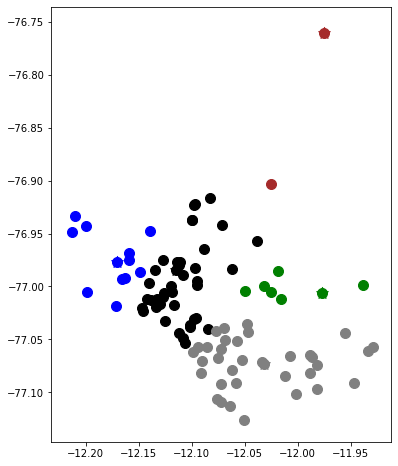

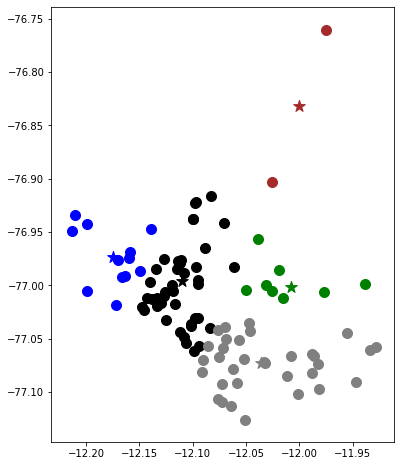

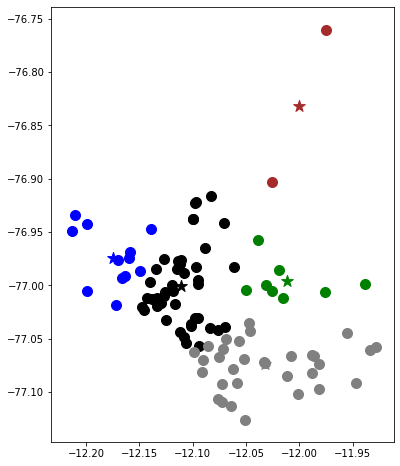

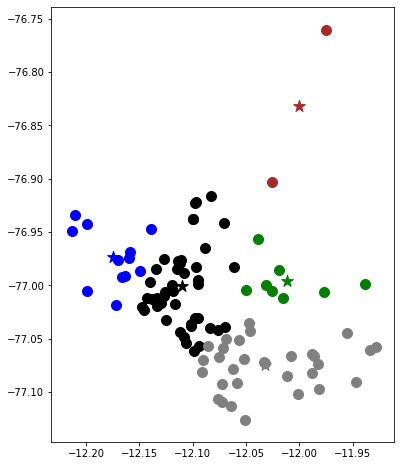

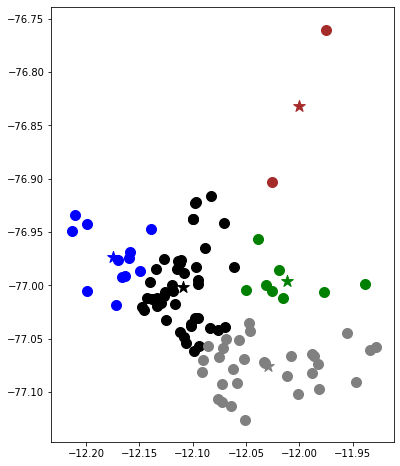

In [90]:
%%time
from collections import Counter
kmeans = FacilityEstimator(6, cluster_iter=10, distance_function=get_time_function(route), optimize_iterations=True)
kmeans.fit(cut[['lat', 'lng']].values, 
           cut.cast_fecha_hora.values,
           cut.fecha_hora_culminacion_proveedor.values)


In [91]:
from sklearn.cluster import KMeans

normal_kmeans = KMeans(6, random_state=0, max_iter=10)
normal_kmeans.fit(cut[['lat', 'lng']].values)

KMeans(max_iter=10, n_clusters=6, random_state=0)

In [28]:
cut['indice'] = np.arange(len(cut))


In [52]:
df_val.shape

(85, 119)

In [53]:
#cut.to_csv('../../')
df_val.to_csv(f'../../../Outputs/comparacion/atenciones_filtradas.csv', index=False)


In [92]:
import numpy as np
from sklearn.cluster import KMeans
if True:
    if True:
        print('Init cluster')
        df_routes_tot = []
        amb_n = 4
        for ix_amb, amb_point in enumerate(kmeans.cluster_centers_):
            print(ix_amb, amb_point)
            for ix_sini, sini_point in enumerate(df_val[['lat', 'lng']].values):
                #stops = "-122.68782,45.51238;-122.690176,45.522054;-122.614995,45.526201"
                stops = f"{amb_point[1]},{amb_point[0]};{sini_point[1]},{sini_point[0]}"

                result = route.solve(stops=stops,
                                     start_time="now",
                                     return_directions=True,
                                     directions_language="es",)

                output_routes = arcgis.features.FeatureSet.from_dict(result["routes"]).sdf

                output_routes['id_sini'] = cut.iloc[ix_sini].indice
                output_routes['id_amb'] = ix_amb
                output_routes['lat_amb'] = amb_point[0]
                output_routes['lng_amb'] = amb_point[1]
                output_routes['lat_sini'] = sini_point[0]
                output_routes['lng_sini'] = sini_point[1]
                
                output_routes['fecha_hora_de_apertura'] = cut.iloc[ix_sini].fecha_hora_de_apertura
                output_routes['intervalos_de_tiempo_de_espera_del_asegurado'] = cut.iloc[ix_sini].intervalos_de_tiempo_de_espera_del_asegurado
                output_routes['fecha_hora_de_asignacion_al_proveedor'] = cut.iloc[ix_sini].fecha_hora_de_asignacion_al_proveedor
                output_routes['fecha_hora_culminacion_proveedor'] = cut.iloc[ix_sini].fecha_hora_culminacion_proveedor

                df_routes_tot.append(output_routes[['fecha_hora_culminacion_proveedor', 'fecha_hora_de_asignacion_al_proveedor', 'intervalos_de_tiempo_de_espera_del_asegurado', 'fecha_hora_de_apertura', 'id_sini', 'lat_sini', 'lng_sini', 'id_amb', 'lat_amb', 'lng_amb', "Name", "Total_TravelTime", "Total_Miles", "Total_Kilometers"]])
    
        df_routes_tot = pd.concat(df_routes_tot)
        df_routes_tot.to_csv(f'../../../Outputs/comparacion/results/all_data_result_16.csv', index=False)
        

Init cluster
0 [-12.10947672 -77.00197277]
1 [-12.02969185 -77.07532936]
2 [-12.0001492  -76.83183825]
3 [-12.17498717 -76.97389314]
4 [-12.01184465 -76.99619341]
5 [-11.8569888 -77.1275265]


In [93]:
import numpy as np
from sklearn.cluster import KMeans
if True:
    if True:
        print('Init cluster')
        df_routes_tot = []
        amb_n = 4
        for ix_amb, amb_point in enumerate(normal_kmeans.cluster_centers_):
            print(ix_amb, amb_point)
            for ix_sini, sini_point in enumerate(df_val[['lat', 'lng']].values):
                #stops = "-122.68782,45.51238;-122.690176,45.522054;-122.614995,45.526201"
                stops = f"{amb_point[1]},{amb_point[0]};{sini_point[1]},{sini_point[0]}"

                result = route.solve(stops=stops,
                                     start_time="now",
                                     return_directions=True,
                                     directions_language="es",)

                output_routes = arcgis.features.FeatureSet.from_dict(result["routes"]).sdf

                output_routes['id_sini'] = cut.iloc[ix_sini].indice
                output_routes['id_amb'] = ix_amb
                output_routes['lat_amb'] = amb_point[0]
                output_routes['lng_amb'] = amb_point[1]
                output_routes['lat_sini'] = sini_point[0]
                output_routes['lng_sini'] = sini_point[1]
                
                output_routes['fecha_hora_de_apertura'] = cut.iloc[ix_sini].fecha_hora_de_apertura
                output_routes['intervalos_de_tiempo_de_espera_del_asegurado'] = cut.iloc[ix_sini].intervalos_de_tiempo_de_espera_del_asegurado
                output_routes['fecha_hora_de_asignacion_al_proveedor'] = cut.iloc[ix_sini].fecha_hora_de_asignacion_al_proveedor
                output_routes['fecha_hora_culminacion_proveedor'] = cut.iloc[ix_sini].fecha_hora_culminacion_proveedor

                df_routes_tot.append(output_routes[['fecha_hora_culminacion_proveedor', 'fecha_hora_de_asignacion_al_proveedor', 'intervalos_de_tiempo_de_espera_del_asegurado', 'fecha_hora_de_apertura', 'id_sini', 'lat_sini', 'lng_sini', 'id_amb', 'lat_amb', 'lng_amb', "Name", "Total_TravelTime", "Total_Miles", "Total_Kilometers"]])
    
        df_routes_tot = pd.concat(df_routes_tot)
        df_routes_tot.to_csv(f'../../../Outputs/comparacion/results/all_data_result_6.csv', index=False)
        

Init cluster
0 [-12.07601717 -77.06344935]
1 [-11.97611387 -77.06042563]
2 [-12.14123451 -76.99292922]
3 [-11.9747601 -76.7604373]
4 [-12.0656239  -76.95764818]
5 [-11.8569888 -77.1275265]


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/geopandas/plotting.py:376: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


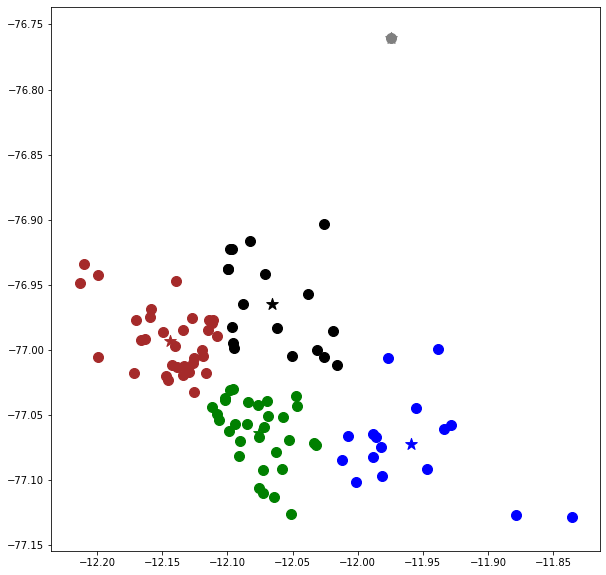

In [45]:
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rc('figure', figsize=(8, 8))

import geopandas as gpd
from shapely.geometry import Point, Polygon

fig, ax = plt.subplots(figsize=(10,10))

types = []
all_points = []

for ix in range(5):
    temp = [Point(x, y) for lab, x, y in zip(normal_kmeans.labels_, cut.lat.values, cut.lng.values) if lab == ix]
    all_points += temp
    types += [ix] * len(temp)

temp = [Point(x, y) for lab, x, y in zip(normal_kmeans.labels_, cut.lat.values, cut.lng.values) if lab == -1]
all_points += temp
types += [5] * len(temp)

for ix in range(5):
    temp = [Point(x, y) for x, y in [normal_kmeans.cluster_centers_[ix]]]
    all_points += temp
    types += [6 + ix] * len(temp)



results = pd.DataFrame()
results['geometry'] = all_points
results['types'] = types

df_geo = gpd.GeoDataFrame(results, geometry=all_points)
df_geo.loc[df_geo.types == 0].geometry.plot(ax=ax, color="green", markersize=100)
df_geo.loc[df_geo.types == 1].geometry.plot(ax=ax, color="black", markersize=100)
df_geo.loc[df_geo.types == 2].geometry.plot(ax=ax, color="blue", markersize=100)
df_geo.loc[df_geo.types == 3].geometry.plot(ax=ax, color="brown", markersize=100)
df_geo.loc[df_geo.types == 4].geometry.plot(ax=ax, color="gray", markersize=100)
df_geo.loc[df_geo.types == 5].geometry.plot(ax=ax, color="red", markersize=100)

df_geo.loc[df_geo.types == 6].geometry.plot(ax=ax, color="green", markersize=150, marker='*')
df_geo.loc[df_geo.types == 7].geometry.plot(ax=ax, color="black", markersize=150, marker='*')
df_geo.loc[df_geo.types == 8].geometry.plot(ax=ax, color="blue", markersize=150, marker='*')
df_geo.loc[df_geo.types == 9].geometry.plot(ax=ax, color="brown", markersize=150, marker='*')
df_geo.loc[df_geo.types == 10].geometry.plot(ax=ax, color="gray", markersize=150, marker='*')


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/geopandas/plotting.py:376: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


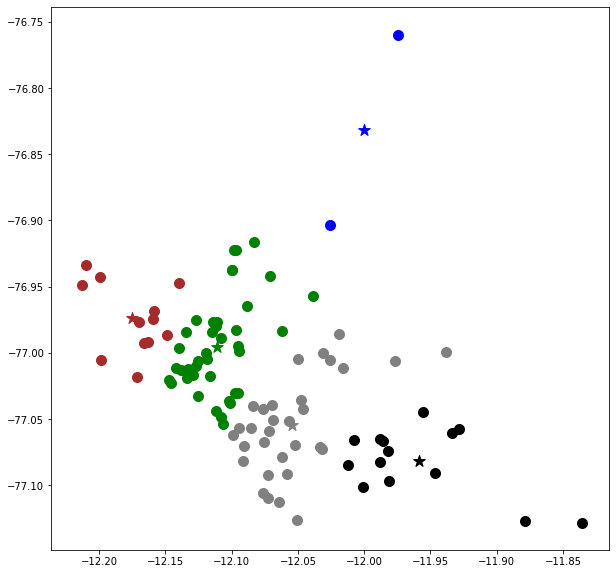

In [79]:
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rc('figure', figsize=(8, 8))

import geopandas as gpd
from shapely.geometry import Point, Polygon

fig, ax = plt.subplots(figsize=(10,10))

types = []
all_points = []

for ix in range(5):
    temp = [Point(x, y) for lab, x, y in zip(kmeans.labels, cut.lat.values, cut.lng.values) if lab == ix]
    all_points += temp
    types += [ix] * len(temp)

temp = [Point(x, y) for lab, x, y in zip(kmeans.labels, cut.lat.values, cut.lng.values) if lab == -1]
all_points += temp
types += [5] * len(temp)

for ix in range(5):
    temp = [Point(x, y) for x, y in [kmeans.cluster_centers_[ix]]]
    all_points += temp
    types += [6 + ix] * len(temp)



results = pd.DataFrame()
results['geometry'] = all_points
results['types'] = types

df_geo = gpd.GeoDataFrame(results, geometry=all_points)
df_geo.loc[df_geo.types == 0].geometry.plot(ax=ax, color="green", markersize=100)
df_geo.loc[df_geo.types == 1].geometry.plot(ax=ax, color="black", markersize=100)
df_geo.loc[df_geo.types == 2].geometry.plot(ax=ax, color="blue", markersize=100)
df_geo.loc[df_geo.types == 3].geometry.plot(ax=ax, color="brown", markersize=100)
df_geo.loc[df_geo.types == 4].geometry.plot(ax=ax, color="gray", markersize=100)
df_geo.loc[df_geo.types == 5].geometry.plot(ax=ax, color="red", markersize=100)

df_geo.loc[df_geo.types == 6].geometry.plot(ax=ax, color="green", markersize=150, marker='*')
df_geo.loc[df_geo.types == 7].geometry.plot(ax=ax, color="black", markersize=150, marker='*')
df_geo.loc[df_geo.types == 8].geometry.plot(ax=ax, color="blue", markersize=150, marker='*')
df_geo.loc[df_geo.types == 9].geometry.plot(ax=ax, color="brown", markersize=150, marker='*')
df_geo.loc[df_geo.types == 10].geometry.plot(ax=ax, color="gray", markersize=150, marker='*')


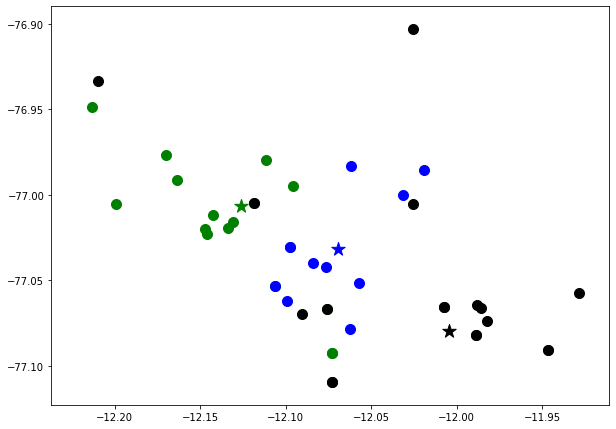

In [93]:
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rc('figure', figsize=(8, 8))

import geopandas as gpd
from shapely.geometry import Point, Polygon

fig, ax = plt.subplots(figsize=(10,10))
cut = data.head(50)
amb_points_1 = [Point(x, y) for x, y in [kmeans.cluster_centers_[1]]]
amb_points_2 = [Point(x, y) for x, y in [kmeans.cluster_centers_[2]]]
amb_points_3 = [Point(x, y) for x, y in [kmeans.cluster_centers_[3]]]
points_1 = [Point(x, y) for lab, x, y in zip(kmeans.labels, cut.lat.values, cut.lng.values) if lab == 1]
points_2 = [Point(x, y) for lab, x, y in zip(kmeans.labels, cut.lat.values, cut.lng.values) if lab == 2]
points_3 = [Point(x, y) for lab, x, y in zip(kmeans.labels, cut.lat.values, cut.lng.values) if lab == 3]
#red_points = [Point(x, y) for lab, x, y in zip(kmeans.labels, data.lat.values, data.lng.values) if lab == 1]

all_points = list(amb_points_1) + list(amb_points_2) + list(amb_points_3) + \
        list(points_1) + list(points_2) + list(points_3)
types = [4]*len(amb_points_1) + [5]*len(amb_points_2) + [6]*len(amb_points_3) + \
        [1]*len(points_1) + [2]*len(points_2) + [3]*len(points_3)

results = pd.DataFrame()
results['geometry'] = all_points
results['types'] = types

df_geo = gpd.GeoDataFrame(results, geometry=all_points)
df_geo.loc[df_geo.types == 1].geometry.plot(ax=ax, color="green", markersize=100)
df_geo.loc[df_geo.types == 2].geometry.plot(ax=ax, color="black", markersize=100)
df_geo.loc[df_geo.types == 3].geometry.plot(ax=ax, color="blue", markersize=100)
df_geo.loc[df_geo.types == 4].geometry.plot(ax=ax, color="green", markersize=200, marker='*')
df_geo.loc[df_geo.types == 5].geometry.plot(ax=ax, color="black", markersize=200, marker='*')
df_geo.loc[df_geo.types == 6].geometry.plot(ax=ax, color="blue", markersize=200, marker='*')


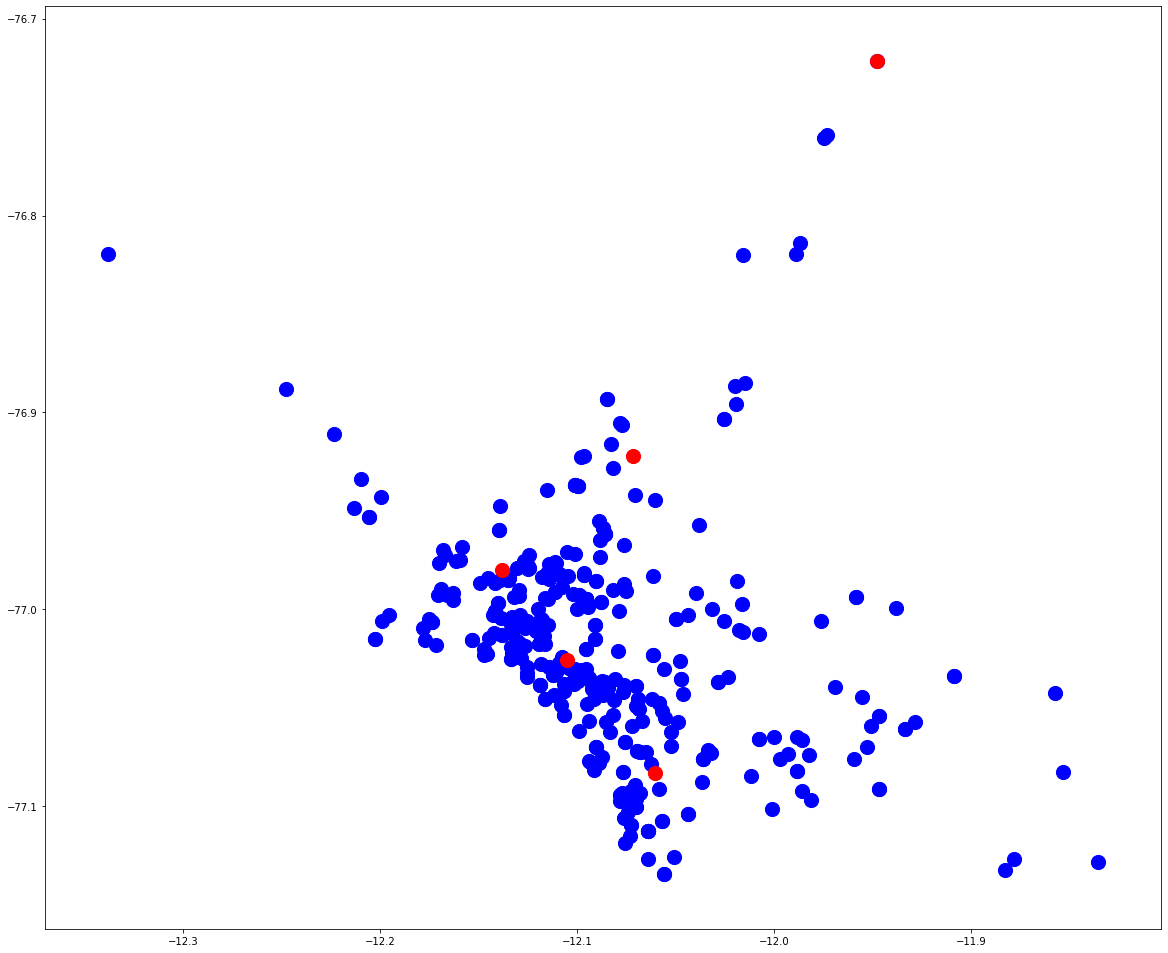

In [58]:
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rc('figure', figsize=(8, 8))

import geopandas as gpd
from shapely.geometry import Point, Polygon

fig, ax = plt.subplots(figsize=(20,20))

amb_points = [Point(x, y) for x, y in kmeans.cluster_centers_]
red_points = [Point(x, y) for x, y in zip(data.lat.values, data.lng.values)]

all_points = list(red_points) + amb_points
types = [0]*len(red_points) + [1]*len(amb_points)

results = pd.DataFrame()
results['geometry'] = all_points
results['types'] = types

df_geo = gpd.GeoDataFrame(results, geometry=all_points)
df_geo.loc[df_geo.types == 0].geometry.plot(ax=ax, color="blue", markersize=200)
df_geo.loc[df_geo.types == 1].geometry.plot(ax=ax, color="red", markersize=200)

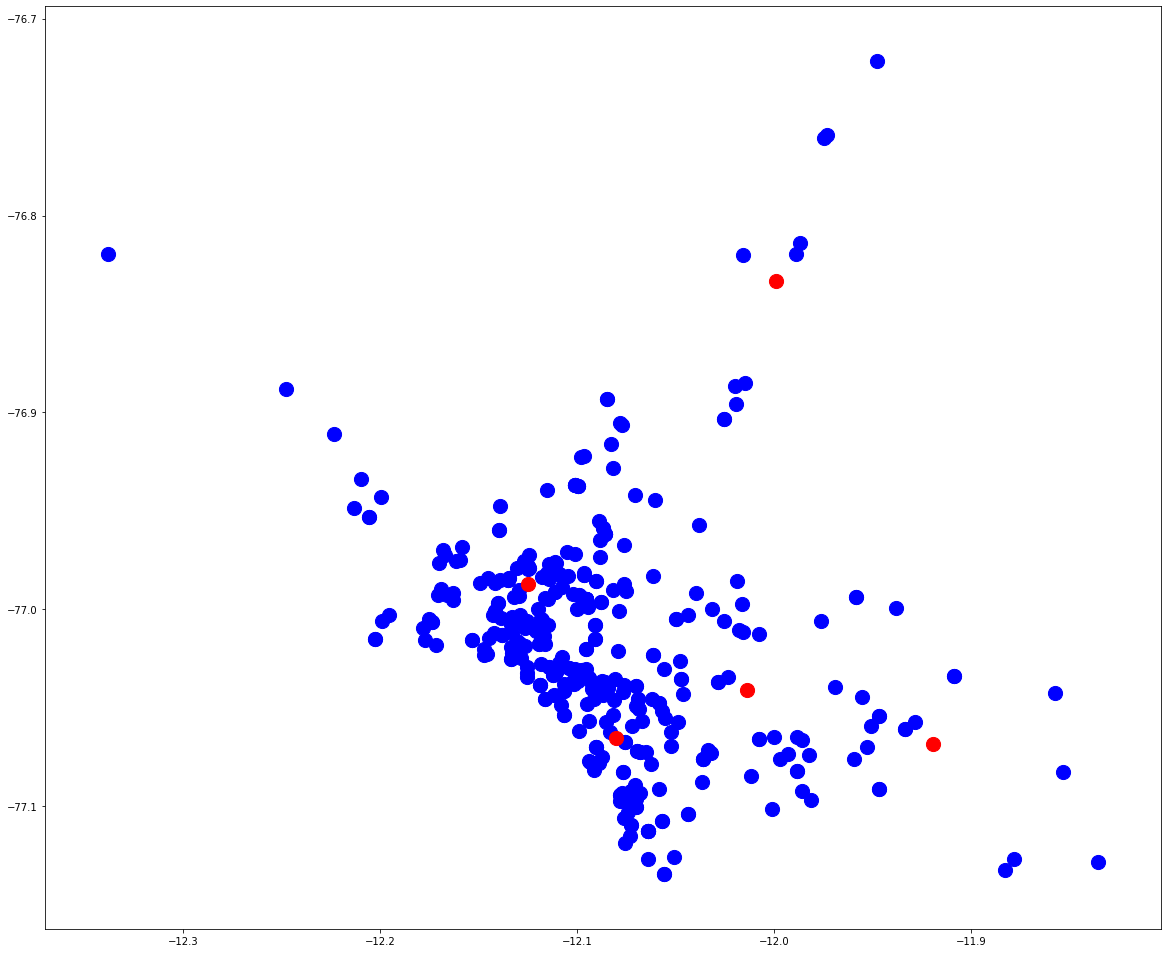

In [29]:
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rc('figure', figsize=(8, 8))

import geopandas as gpd
from shapely.geometry import Point, Polygon

fig, ax = plt.subplots(figsize=(20,20))

amb_points = [Point(x, y) for x, y in kmeans.cluster_centers_]
red_points = [Point(x, y) for x, y in zip(data.lat.values, data.lng.values)]

all_points = list(red_points) + amb_points
types = [0]*len(red_points) + [1]*len(amb_points)

results = pd.DataFrame()
results['geometry'] = all_points
results['types'] = types

df_geo = gpd.GeoDataFrame(results, geometry=all_points)
df_geo.loc[df_geo.types == 0].geometry.plot(ax=ax, color="blue", markersize=200)
df_geo.loc[df_geo.types == 1].geometry.plot(ax=ax, color="red", markersize=200)